# Information Extraction from Similar Co-Occurring Entities
This notebook contains the necessary code for reproducing the results of the paper "Information Extraction from Similar Co-Occurring Entities". The functionality for extracting new entities and facts for CaLiGraph is already implemented in the extraction framework. Here, we simply run this functionality to show the results and extend some parts to extract results for DBpedia as well.

To reproduce the results, parts of the CaLiGraph extraction framework need to be run first. If necessary, the extraction will be triggered automatically from this notebook. A full run of this notebook needs roughly two days (plus three additional days when running the extraction framework). For hardware requirements, refer to the README.

Evaluation results of the paper and all triples produced in this notebook can be downloaded [here](http://data.dws.informatik.uni-mannheim.de/CaLiGraph/www2021/).

*Note: The results produced here differ slightly from the results of the paper as we use new Wikipedia and DBpedia dumps from 2020 instead of from 2016.*

## Preparations

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_rows = 50
pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 100

import impl.dbpedia.store as dbp_store
import impl.dbpedia.util as dbp_util
import impl.util.rdf as rdf_util
import impl.util.serialize as serialize_util
from impl import caligraph
import impl.caligraph.util as clg_util
from impl.listing import context, extract

2021-03-03 16:50:32,375 DEBUG: RDFLib Version: 5.0.0


In [2]:
# load data
graph = caligraph.get_axiom_graph()
df = context.retrieve_page_entity_context(graph)

2021-03-03 20:15:32,126 INFO: Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-03-03 20:15:32,130 INFO: NumExpr defaulting to 8 threads.


## Type Extraction for *DBpedia*

In [3]:
# compute valid combinations of types and NE tags

def _get_transitive_types_dbp(entity_name: str) -> set:
    dbp_uri = dbp_util.name2resource(str(entity_name))
    transitive_types = dbp_store.get_transitive_types(dbp_uri).difference({rdf_util.CLASS_OWL_THING})
    return {dbp_util.type2name(t) for t in transitive_types}

def _get_valid_tags_for_entity_types_dbp(dft: pd.DataFrame, threshold: float) -> dict:
    tag_probabilities = context._get_tag_probabilities(dft)
    valid_tags = tag_probabilities[tag_probabilities['tag_fit'] >= threshold].groupby('E_enttype')['E_tag'].apply(lambda x: x.values.tolist()).to_dict()
    for ent_type in set(valid_tags):  # assign tags of parents to types without tags (to avoid inconsistencies)
        valid_tags[ent_type] = _compute_valid_tags_for_type_dbp(ent_type, valid_tags)
    return valid_tags

def _compute_valid_tags_for_type_dbp(ent_type: str, valid_tags: dict) -> set:
    if ent_type not in valid_tags:
        return set()
    if not valid_tags[ent_type]:
        valid_tags[ent_type] = {tag for ptype in _get_supertypes_dbp(ent_type) for tag in _compute_valid_tags_for_type_dbp(ptype, valid_tags)}
    return valid_tags[ent_type]

def _get_supertypes_dbp(type_name: str) -> set:
    dbp_type = dbp_util.name2type(str(type_name))
    return {dbp_util.type2name(t) for t in dbp_store.get_supertypes(dbp_type).difference({rdf_util.CLASS_OWL_THING})}

df_types_dbp = pd.DataFrame([{'E_ent': ent, 'E_enttype': t} for ent in df['E_ent'].unique() for t in _get_transitive_types_dbp(ent)])
dft_dbp = pd.merge(left=df, right=df_types_dbp, on='E_ent')
valid_tags_dbp = _get_valid_tags_for_entity_types_dbp(dft_dbp, .35)


In [23]:
# extract rules

rule_dfs_dbp = {}
for rule_name, rule_pattern in extract.RULE_PATTERNS.items():
    dft_by_page = extract._aggregate_types_by_page(dft_dbp, rule_pattern)
    rule_dfs_dbp[rule_name] = extract._aggregate_types_by_section(dft_by_page, rule_pattern)

### Threshold Selection

In [24]:
# extract all possible new types up to a very low threshold (mean >= 0.25 and std <= 0.75)

threshold_rule_dfs_dbp = [rule_dfs_dbp[rule_name].query(f'micro_mean > .25 & micro_std < .75').reset_index()[rule_pattern + ['E_enttype', 'micro_mean', 'micro_std']].drop_duplicates() for rule_name, rule_pattern in extract.RULE_PATTERNS.items()]
threshold_types_dbp = extract._extract_new_types(threshold_rule_dfs_dbp, df, df_types_dbp)

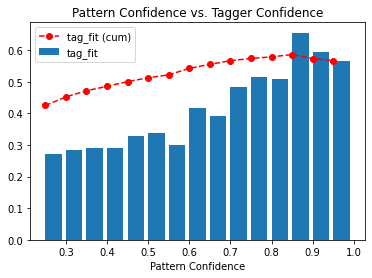

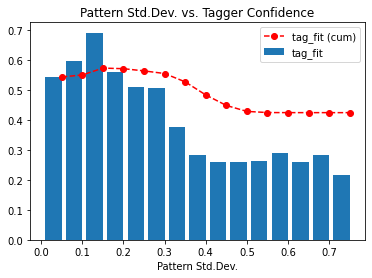

In [25]:
def visualise_type_thresholds(df, tag_probabilities, bin_count):
    """Visualize the tag fit in relation to the confidence and consistency (here: std)."""
    df = pd.merge(df, tag_probabilities, on=['E_enttype', 'E_tag'])
    
    min_mean = .25
    mean_conf_labels = [min_mean + x / bin_count * (1 - min_mean) for x in range(bin_count)]
    df['mean_confidence'] = pd.cut(df['micro_mean'], bin_count, labels=mean_conf_labels)
    
    # per bin
    plt.bar(x=mean_conf_labels, height=df.groupby('mean_confidence')['tag_fit'].mean().values, width=(1-min_mean)/bin_count*0.8, align='edge', label='tag_fit')
    # cumulative
    cumulative_tag_fit = [df[df['micro_mean'] > x]['tag_fit'].mean() for x in mean_conf_labels]
    plt.plot(mean_conf_labels, cumulative_tag_fit, 'ro--', label='tag_fit (cum)')
    plt.xlabel('Pattern Confidence')
    plt.title('Pattern Confidence vs. Tagger Confidence')
    plt.legend()
    plt.show()

    max_std = .75
    std_conf_labels = [(x+1) / bin_count * max_std for x in range(bin_count)]
    df['std_confidence'] = pd.cut(df['micro_std'], bin_count, labels=std_conf_labels)

    # per bin
    plt.bar(x=std_conf_labels, height=df.groupby('std_confidence')['tag_fit'].mean().values, width=max_std/bin_count*-0.8, align='edge', label='tag_fit')
    # cumulative
    cumulative_tag_fit = [df[df['micro_std'] < x]['tag_fit'].mean() for x in std_conf_labels]
    plt.plot(std_conf_labels, cumulative_tag_fit, 'ro--', label='tag_fit (cum)')
    plt.xlabel('Pattern Std.Dev.')
    plt.title('Pattern Std.Dev. vs. Tagger Confidence')
    plt.legend()
    plt.show()
        
visualise_type_thresholds(threshold_types_dbp, context._get_tag_probabilities(dft_dbp), 15)

### Results

In [26]:
# filter rules by threshold and compute filtered types

new_types_dbp = extract._extract_new_types_with_threshold(df, df_types_dbp, rule_dfs_dbp)
filtered_types_dbp = extract._filter_new_types_by_tag(new_types_dbp, valid_tags_dbp)

In [28]:
filtered_types_dbp.sample(20)

,P_basetype,TS_text,E_enttype,micro_mean,micro_std,P,E_ent,E_text,E_tag,TS_ent,S_text,S_ent,E_id,TS_enttype,S_enttype,P_type
29480310,Work,Personnel,Person,0.973151,0.045563,Vanished Gardens,Vanished Gardens--Bernie Grundman,Bernie Grundman,PERSON,None,Personnel,None,39380735.0,NaN,NaN,Album
18362792,Other,People,Person,0.990274,0.019795,Menasce,Daniel Menasce,Daniel Menasce,PERSON,None,People,None,38921168.0,NaN,NaN,Other
20987372,Other,Species,Eukaryote,0.991329,0.015792,Coelotes,Coelotes striatilamnis,Coelotes s. ketmenensis,OTHER,None,Species,None,33212227.0,NaN,NaN,Other
31684226,Organisation,First World War,Organisation,1.000000,0.000000,6th (United Kingdom) Division,6th (United Kingdom) Division--9th (Service),9th (Service),ORG,World War I,Later in the War,None,4250374.0,MilitaryConflict,NaN,MilitaryUnit
29948623,Work,Track listing,MusicalWork,0.943174,0.103822,A Picture of Me (Without You),A Picture of Me (Without You)--She Loves Me (Right Out of My Mind),She Loves Me (Right Out of My Mind),WORK_OF_ART,None,Track listing,None,16758878.0,NaN,NaN,Album
9052004,Location,Stores,Company,0.983471,0.023047,Eastport Plaza,Eastport Plaza--Nail Tek,Nail Tek,ORG,None,Stores,None,30609099.0,NaN,NaN,ShoppingMall
28487131,Work,Personnel,Artist,0.878850,0.140657,SimetriSiti,SimetriSiti--Jay Franco,Jay Franco,PERSON,None,Personnel,None,37829447.0,NaN,NaN,Album
34360607,Other,Rolling stock,MeanOfTransportation,1.000000,0.000000,Kamome,Kamome--485 series EMUs,485 series EMUs,PRODUCT,None,Rolling stock used in the past,None,16899907.0,NaN,NaN,Other
21119704,Other,Species,Species,0.999608,0.002107,Gagea,Gagea hiensis,Gagea hiensis,OTHER,None,Species,None,7517175.0,NaN,NaN,Other
2532341,List,Champions by year,Athlete,0.981884,0.112793,List of Grand Slam men's singles champions,Ashley Cooper (tennis player),Ashley Cooper,PERSON,None,Champions by year,None,8457320.0,NaN,NaN,List


In [29]:
filtered_types_dbp.sample(20)[['E_text', 'E_enttype']]

,E_text,E_enttype
14654325,Nicolae Negumereanu,MartialArtist
29470332,Ergun,Person
14416762,Nilkanth Singh Munda,Politician
21230683,Medetera valaisensis,Species
24549197,Daïnah la métisse,Work
29966481,Steady Rain,MusicalWork
15827202,Harry Weisberg,Agent
30065800,Slide Show,MusicalWork
26804418,Amelia Wiśniewska,Agent
29313304,Joshua Levy-,Person


In [20]:
# write new types to file
def serialize_types_dbp(df, filename):
    triples = [serialize_util.as_object_triple(dbp_util.name2resource(r['E_ent']), rdf_util.PREDICATE_TYPE, dbp_util.name2type(r['E_enttype'])) for _, r in df.iterrows()]
    with open(filename, mode='w') as f:
        f.writelines(triples)

serialize_types_dbp(filtered_types_dbp, 'new_types_dbpedia.nt')

## Type Extraction for *CaLiGraph*

In [4]:
# compute valid combinations of types and NE tags

df_types_clg = context.get_entity_types(df, graph)
dft_clg = pd.merge(left=df, right=df_types_clg, on='E_ent')
valid_tags_clg = context.get_valid_tags_for_entity_types(dft_clg, graph, .35)

In [5]:
# extract rules

rule_dfs_clg = {}
for rule_name, rule_pattern in extract.RULE_PATTERNS.items():
    dft_by_page = extract._aggregate_types_by_page(dft_clg, rule_pattern)
    rule_dfs_clg[rule_name] = extract._aggregate_types_by_section(dft_by_page, rule_pattern)

### Results

In [6]:
# filter rules by threshold and compute filtered types

new_types_clg = extract._extract_new_types_with_threshold(df, df_types_clg, rule_dfs_clg)
filtered_types_clg = extract._filter_new_types_by_tag(new_types_clg, valid_tags_clg)

In [ ]:
# write new types to file

def serialize_types_clg(df, filename):
    triples = [serialize_util.as_object_triple(clg_util.name2clg_resource(r['E_ent']), rdf_util.PREDICATE_TYPE, clg_util.name2clg_type(r['E_enttype'])) for _, r in df.iterrows()]
    with open(filename, mode='w') as f:
        f.writelines(triples)

serialize_types_clg(filtered_types_clg, 'new_types_caligraph.nt')

## Relation Extraction

In [4]:
# retrieve existing relations

df_rels = context.get_entity_relations()

### Threshold Selection

In [5]:
# extract all possible rules for relations with PageEntity as target

rule_dfs = {}
dfr = extract._create_relation_df(df, df_rels, 'P')
dfr_types = extract._create_relation_type_df(dfr)
for rule_name, rule_pattern in extract.RULE_PATTERNS.items():
    dfr_by_page = extract._aggregate_relations_by_page(df, dfr, df_rels, rule_pattern)
    rule_dfs[rule_name] = extract._aggregate_relations_by_section(dfr_by_page, rule_pattern)

In [6]:
# generate all possible relations up to a very low threshold (mean > 0.25 and std < 0.75)
threshold_rule_dfs = [rule_dfs[rule_name].query(f'page_count > 2 & micro_mean > .25 & micro_std < .75').reset_index()[rule_pattern + ['rel', 'micro_mean', 'micro_std']].drop_duplicates() for rule_name, rule_pattern in extract.RULE_PATTERNS.items()]
threshold_relations = extract._extract_new_relations(threshold_rule_dfs, 'P', df, dfr_types, df_rels)

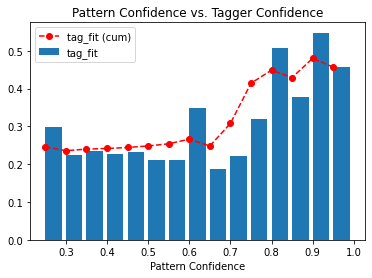

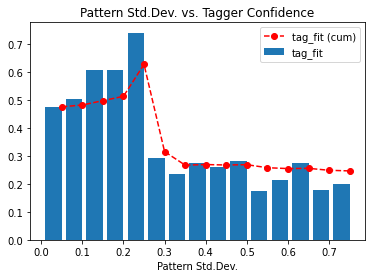

In [10]:
# visualise thresholds

def visualise_relation_thresholds(df, target, tag_probabilities, bin_count):    
    """Visualize the tag fit in relation to the confidence and consistency (here: std)."""
    # add tag_fit
    df = pd.merge(df, tag_probabilities, left_on=['E_predtype', 'E_tag'], right_on=['E_enttype', 'E_tag'])
    
    min_mean = .25
    mean_conf_labels = [min_mean + x / bin_count * (1 - min_mean) for x in range(bin_count)]
    df['mean_confidence'] = pd.cut(df['micro_mean'], bin_count, labels=mean_conf_labels)
    max_std = .75
    std_conf_labels = [(x+1) / bin_count * max_std for x in range(bin_count)]
    df['std_confidence'] = pd.cut(df['micro_std'], bin_count, labels=std_conf_labels)
    
    ## tag_fit with confidence ##
    # per bin
    plt.bar(x=mean_conf_labels, height=df.groupby('mean_confidence')['tag_fit'].mean().values, width=(1-min_mean)/bin_count*0.8, align='edge', label='tag_fit')
    # cumulative
    cumulative_tag_fit = [df[df['micro_mean'] > x]['tag_fit'].mean() for x in mean_conf_labels]
    plt.plot(mean_conf_labels, cumulative_tag_fit, 'ro--', label='tag_fit (cum)')
    plt.xlabel('Pattern Confidence')
    plt.title('Pattern Confidence vs. Tagger Confidence')
    plt.legend()
    plt.show()
    
    ## tag_fit with consistency ##
    # per bin
    plt.bar(x=std_conf_labels, height=df.groupby('std_confidence')['tag_fit'].mean().values, width=max_std/bin_count*-0.8, align='edge', label='tag_fit')
    # cumulative
    cumulative_tag_fit = [df[df['micro_std'] < x]['tag_fit'].mean() for x in std_conf_labels]
    plt.plot(std_conf_labels, cumulative_tag_fit, 'ro--', label='tag_fit (cum)')
    plt.xlabel('Pattern Std.Dev.')
    plt.title('Pattern Std.Dev. vs. Tagger Confidence')
    plt.legend()
    plt.show()
    
visualise_relation_thresholds(threshold_relations, 'P', context._get_tag_probabilities(dft_dbp), 15)

### Results

In [12]:
# retrieve new relations for all three targets
df_new_relations = extract._compute_new_relations(df, df_rels, 'P', valid_tags_dbp)
df_new_relations = pd.concat([df_new_relations, extract._compute_new_relations(df, df_rels, 'TS_ent', valid_tags_dbp)])
df_new_relations = pd.concat([df_new_relations, extract._compute_new_relations(df, df_rels, 'S_ent', valid_tags_dbp)])

In [16]:
df_new_relations.sample(20)

,P_basetype,TS_text,rel,micro_mean,micro_std,P,E_ent,E_text,E_tag,TS_ent,S_text,S_ent,E_id,TS_enttype,S_enttype,P_type,pred,inv,E_predtype,target
1804314,Other,Species,< genus <,0.977019,0.045419,Halimuraena,Halimuraena shakai,Halimuraena shakai,SPECIES,None,Species,None,39648306,NaN,NaN,Other,http://dbpedia.org/ontology/genus,True,Species,Halimuraena
216985,Location,Communities,< subdivision <,0.957367,0.098188,"Christian County, Missouri","Chadwick, Missouri",Chadwick,GPE,None,Other unincorporated communities,None,1353294,NaN,NaN,AdministrativeRegion,http://dbpedia.org/ontology/subdivision,True,PopulatedPlace,"Christian County, Missouri"
107055,List,Odonata,< order <,1.000000,0.000000,List of least concern insects,Pinheyschna subpupillata,Stream hawker,SPECIES,Odonata,Aeshnids,Aeshnidae,36319656,NaN,NaN,List,http://dbpedia.org/ontology/order,True,Species,Odonata
1650594,Other,Species,< genus <,0.977019,0.045419,Eupoecilia,Eupoecilia kruegeriana,Eupoecilia kruegeriana,SPECIES,None,Species,None,25698774,NaN,NaN,Other,http://dbpedia.org/ontology/genus,True,Species,Eupoecilia
61042,List,Gastropods,< family <,1.000000,0.000000,List of vulnerable molluscs,Brotia wykoffi,Brotia wykoffi,SPECIES,Gastropoda,Pachychilids,Pachychilidae,36300492,NaN,NaN,List,http://dbpedia.org/ontology/family,True,Species,Pachychilidae
1732647,Other,Species,< genus <,0.977019,0.045419,Leptoneta,Leptoneta maculosa,L. maculosa,OTHER,None,Species,None,37360208,NaN,NaN,Other,http://dbpedia.org/ontology/genus,True,Species,Leptoneta
2084439,Species,Species,< genus <,0.984059,0.029726,Triphora (gastropod),Triphora dalli,Triphora dalli,SPECIES,Species,Species,Species,32364528,NaN,NaN,Mollusca,http://dbpedia.org/ontology/genus,True,Species,Triphora (gastropod)
654105,Person,Directing filmography,< director <,1.000000,0.000000,Jonathan Frakes,Jonathan Frakes--All or Nothing,All or Nothing,WORK_OF_ART,None,Television,None,1103264,NaN,NaN,Person,http://dbpedia.org/ontology/director,True,Film,Jonathan Frakes
806033,Person,Film scores,< musicComposer <,0.873288,0.154829,Don Preston,The Underachievers (film),The Underachievers,WORK_OF_ART,None,Film scores,None,12602413,NaN,NaN,MusicalArtist,http://dbpedia.org/ontology/musicComposer,True,Work,Don Preston
611381,Organisation,Singles,< artist <,0.903226,0.130987,La Factoría,La Factoría--Amiga,Amiga,WORK_OF_ART,None,Singles,None,21081955,NaN,NaN,Band,http://dbpedia.org/ontology/artist,True,MusicalWork,La Factoría


In [22]:
df_new_relations.sample(20)[['target', 'rel', 'E_text']]

,target,rel,E_text
274906,Sturgeon County,< subdivision <,Nywening
864833,Anthyllis,< genus <,Anthyllis splendens
1209316,Psilochilus,< genus <,Psilochilus vallecaucanus
228388,"Sumner County, Kansas",< subdivision <,Cicero
1671191,Tethya,< genus <,Tethya irisae
288516,"Eaton County, Michigan",> largestCity >,Eaton Rapids
287348,"Boone County, Missouri",> largestCity >,Ashland
1758229,Ormiscus,< genus <,Ormiscus vulgaris
1748675,Sphecodes,< genus <,Sphecodes mutillaeformis
1787612,Silis (beetle),< genus <,Silis parallela


In [30]:
# write new relations to file

def serialize_relations(df, filename):
    triples = []
    for _, r in df.iterrows():
        s, p, o = clg_util.name2clg_resource(r['target']), r['pred'].replace('dbpedia', 'caligraph'), clg_util.name2clg_resource(r['E_ent'])
        if r['inv']:
            s, o = o, s
        triples.append(serialize_util.as_object_triple(s, p, o))
    with open(filename, mode='w') as f:
        f.writelines(triples)
        
serialize_relations(df_new_relations, 'new_relations.nt')